# Central Configuration Block

In [ ]:

class Config:
    DEBUG = False

    #data
    DATASET = "MNIST"
    IMG_SIZE = 28
    CHANNELS = 1
    TRAIN_SUBSET_SIZE = 10000 if not DEBUG else 1000
    VAL_SUBSET_SIZE = 1000 if not DEBUG else 200
    BATCH_SIZE = 128
    NUM_WORKERS = 2

    # Diffussion
    TIMESTEPS = 300
    BETA_SCHEDULE = "linear"  # or "cosine"
    BETA_START = 0.0001
    BETA_END = 0.02

    # Model
    CHANNELS_LIST = [32, 64, 128]
    TIME_EMB_DIM = 128
    NUM_CLASSES = 10
    CFG_DROPOUT_PROB = 0.15

    # Training
    EPOCHS = 10 if not DEBUG else 2
    LEARNING_RATE = 1e-3

    # Sampling
    SAMPLES_PER_CLASS_VALIDATION = 1 # How
    GUIDANCE_SCALES_TO_VISUALIZE = [0.0, 1.5, 3.0, 7.5] #

# Setup, Version Checks, and Directory Creation

In [ ]:
# --- Imports ---
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# --- Sanity Checks and Versioning ---
# print("--- Versions ---")
# print(f"PyTorch: {torch.__version__}")
# print(f"Torchvision: {torchvision.__version__}")

# GPU and Device Setup
print("\n--- GPU Information ---")
if torch.cuda.is_available():
    gpu_info = !nvidia-smi --query-gpu=gpu_name,memory.total --format=csv,noheader
    print(f"GPU Detected: {gpu_info[0]}")
    device = torch.device("cuda")
else:
    print("No GPU detected. Using CPU.")
    device = torch.device("cpu")

#  Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Output Directories
os.makedirs("/content/outputs/ckpts", exist_ok=True)
os.makedirs("/content/outputs/figures", exist_ok=True)
os.makedirs("/content/outputs/samples", exist_ok=True)

print(f"Device set to: {device}")


--- GPU Information ---
GPU Detected: Tesla T4, 15360 MiB
Device set to: cuda


# 2.1: Load and Prepare MNIST Dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), #  0.0 --> 1.0
    transforms.Normalize((0.5,), (0.5,))   # -1.0 -> 1.0
])

full_train_dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
full_val_dataset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_dataset = Subset(full_train_dataset, range(Config.TRAIN_SUBSET_SIZE))
val_dataset = Subset(full_val_dataset, range(Config.VAL_SUBSET_SIZE))

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)

print(f"\nTraining dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.00MB/s]


Training dataset size: 10000
Validation dataset size: 1000


#  Diffusion Schedule and Forward Process (`q_sample`)

--- Sanity Check: Forward Process ---
x0 batch shape: torch.Size([128, 1, 28, 28])
x0 batch mean: -0.7366, std: 0.6165 (Note: Mean is not 0 due to data distribution)


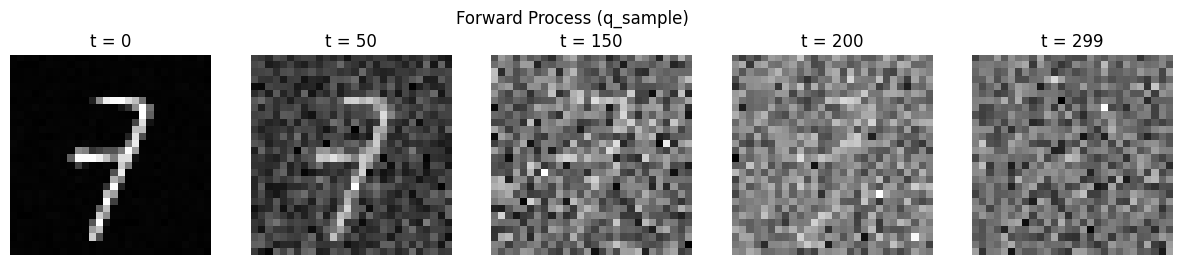

Stats for the entire batch at t=299:
xt batch mean: -0.1604, std: 0.9829
Noise batch mean: 0.0011, std: 0.9978

✅ Sanity check passed! The standard deviation of a fully noised batch is close to 1, as expected.


In [ ]:
# Diffusion Schedule
if Config.BETA_SCHEDULE == "linear":
    betas = torch.linspace(Config.BETA_START, Config.BETA_END, Config.TIMESTEPS, device=device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

# Forward Process (q_sample)
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0, device=device)

    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1. - alphas_cumprod[t]).view(-1, 1, 1, 1)

    xt = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise
    return xt, noise

# Sanity Check: Visualize Forward Process
print("--- Sanity Check: Forward Process ---")
sample_batch = next(iter(train_loader))[0].to(device)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle("Forward Process (q_sample)")
for i, t_val in enumerate([0, 50, 150, 200, Config.TIMESTEPS - 1]):
    t = torch.full((Config.BATCH_SIZE,), t_val, device=device, dtype=torch.long)
    xt_batch, noise_added_batch = q_sample(sample_batch, t)

    xt_single_image = xt_batch[0]

    if i == 0:
        print(f"x0 batch shape: {sample_batch.shape}")
        print(f"x0 batch mean: {sample_batch.mean():.4f}, std: {sample_batch.std():.4f} (Note: Mean is not 0 due to data distribution)")

    axs[i].imshow(xt_single_image.squeeze().cpu().numpy(), cmap='gray')
    axs[i].set_title(f"t = {t_val}")
    axs[i].axis('off')

plt.savefig("/content/outputs/figures/forward_process.png")
plt.show()

# Perform statistical check on the FINAL noised BATCH
print(f"Stats for the entire batch at t={Config.TIMESTEPS-1}:")
print(f"xt batch mean: {xt_batch.mean():.4f}, std: {xt_batch.std():.4f}")
print(f"Noise batch mean: {noise_added_batch.mean():.4f}, std: {noise_added_batch.std():.4f}")


assert torch.allclose(xt_batch.std(), torch.tensor(1.0), atol=0.1), "Std dev of fully noised batch is too far from 1"
print("\n✅ Sanity check passed! The standard deviation of a fully noised batch is close to 1, as expected.")

# 4.1: UNet Model with Time and Class Conditioning

In [ ]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.relu(self.bn1(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        h = h + time_emb.unsqueeze(-1).unsqueeze(-1)
        h = self.relu(self.bn2(self.conv2(h)))
        return h + self.residual_conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, channels=Config.CHANNELS_LIST, time_emb_dim=Config.TIME_EMB_DIM, num_classes=Config.NUM_CLASSES):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.num_classes = num_classes
        self.null_class_token = num_classes
        self.time_mlp = nn.Sequential(SinusoidalPositionEmbeddings(time_emb_dim), nn.Linear(time_emb_dim, time_emb_dim), nn.ReLU())
        self.class_emb = nn.Embedding(num_classes + 1, time_emb_dim)
        self.init_conv = nn.Conv2d(in_channels, channels[0], kernel_size=3, padding=1)
        self.down1 = ResidualBlock(channels[0], channels[1], time_emb_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ResidualBlock(channels[1], channels[2], time_emb_dim)
        self.pool2 = nn.MaxPool2d(2)
        self.bot1 = ResidualBlock(channels[2], channels[2], time_emb_dim)
        self.up1 = nn.ConvTranspose2d(channels[2], channels[1], kernel_size=2, stride=2)
        self.up_res1 = ResidualBlock(channels[1] + channels[2], channels[1], time_emb_dim)
        self.up2 = nn.ConvTranspose2d(channels[1], channels[0], kernel_size=2, stride=2)
        self.up_res2 = ResidualBlock(channels[0] + channels[1], channels[0], time_emb_dim)
        self.out_conv = nn.Conv2d(channels[0], out_channels, kernel_size=1)

    def forward(self, x, t, y):
        assert x.shape[1:] == (Config.CHANNELS, Config.IMG_SIZE, Config.IMG_SIZE), f"Input shape mismatch"
        t_emb = self.time_mlp(t)
        y_emb = self.class_emb(y)
        conditioning = t_emb + y_emb
        x1 = self.init_conv(x)
        x2 = self.down1(x1, conditioning)
        x3 = self.pool1(x2)
        x4 = self.down2(x3, conditioning)
        x5 = self.pool2(x4)
        x_bot = self.bot1(x5, conditioning)
        x_up = self.up1(x_bot)
        x_up = torch.cat([x_up, x4], dim=1)
        x_up = self.up_res1(x_up, conditioning)
        x_up = self.up2(x_up)
        if x_up.shape[2] != x2.shape[2]: x_up = F.pad(x_up, (0, 1, 0, 1))
        x_up = torch.cat([x_up, x2], dim=1)
        x_up = self.up_res2(x_up, conditioning)
        output = self.out_conv(x_up)
        # NaN Check
        if torch.isnan(output).any():
            raise ValueError("NaN detected in model output")
        return output

# 4.2 Sampling Function Definitions

In [ ]:
@torch.no_grad()
def p_sample(model, xt, t, y, guidance_scale):
    """
    Performs a single reverse diffusion step, including classifier-free guidance.
    - xt: The noisy image at timestep t.
    - t: The current timestep.
    - y: The class label for conditioning.
    - guidance_scale: The strength of the guidance.
    """
    # Create a tensor of the current timestep for batch processing
    t_tensor = torch.full((xt.shape[0],), t, device=device, dtype=torch.long)

    # Classifier-Free Guidance ---
    # 1. Get the conditional noise prediction (with the class label)
    noise_pred_cond = model(xt, t_tensor, y)

    # 2. Get the unconditional noise prediction (with the null class token)
    null_y = torch.full_like(y, model.null_class_token)
    noise_pred_uncond = model(xt, t_tensor, null_y)

    # 3. Combine the predictions using the guidance scale
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

    # Denoising Formula
    alpha_t = alphas[t]
    alpha_cumprod_t = alphas_cumprod[t]

    term1 = 1 / torch.sqrt(alpha_t)
    term2 = (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)

    # Denoise the image by subtracting the predicted noise
    xt_minus_1 = term1 * (xt - term2 * noise_pred)

    # Add back a small amount of noise (except for the last step t=0)
    if t > 0:
        beta_t = betas[t]
        noise = torch.randn_like(xt)
        xt_minus_1 += torch.sqrt(beta_t) * noise

    return xt_minus_1

@torch.no_grad()
def sample_loop(model, shape, class_label, guidance_scale=3.0):
    """
    Generates a full sample by running the entire reverse diffusion loop.
    """
    # Start with pure random noise
    x = torch.randn(shape, device=device)

    # Create a tensor for the desired class label
    y = torch.full((shape[0],), class_label, device=device, dtype=torch.long)

    # Store intermediate steps for visualization
    history = []

    # Loop backwards from the last timestep to the first
    for t in tqdm(reversed(range(Config.TIMESTEPS)), desc=f"Sampling Class {class_label}"):
        x = p_sample(model, x, t, y, guidance_scale)

        if t % 30 == 0 or t == 0:
            history.append(x.cpu())

    return x.cpu(), history

# 5.1: Training and Validation Loop with Live Visualization

--- Starting Training ---


Epoch 1 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.1694 | Val Loss: 0.1134


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

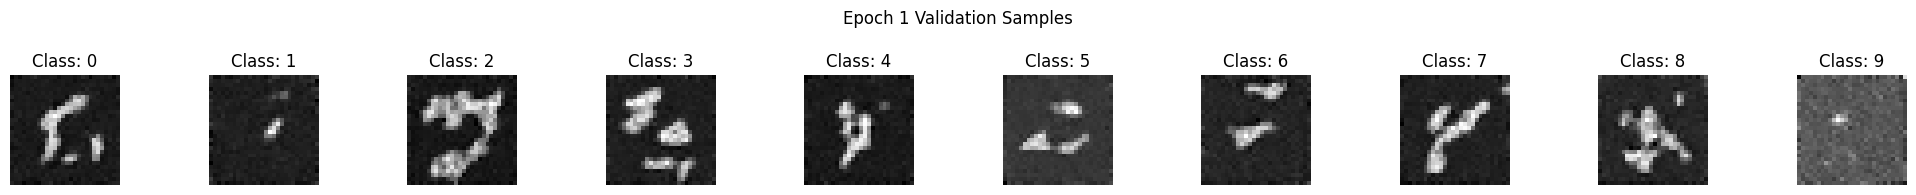

Epoch 2 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.0906 | Val Loss: 0.0845


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

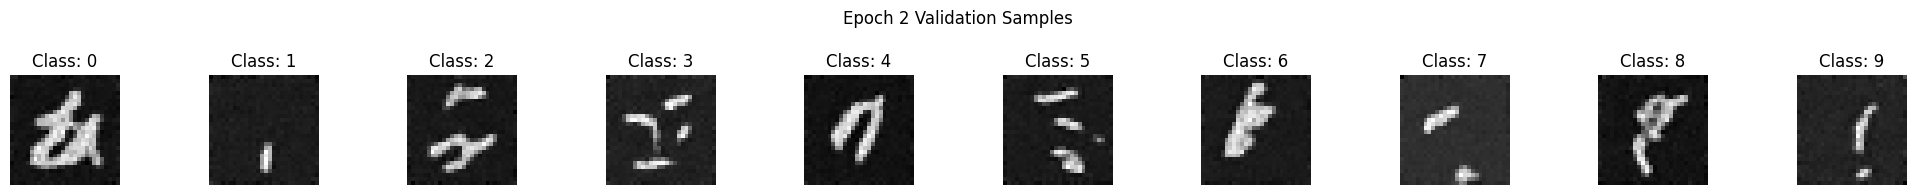

Epoch 3 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.0794 | Val Loss: 0.0736


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

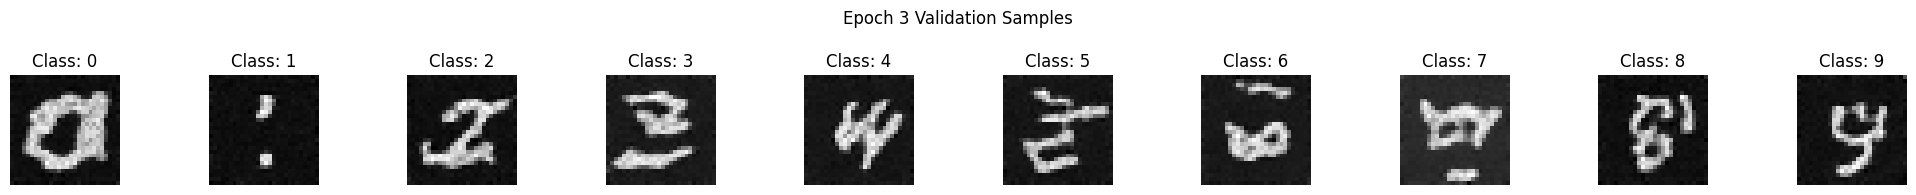

Epoch 4 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.0715 | Val Loss: 0.0681


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

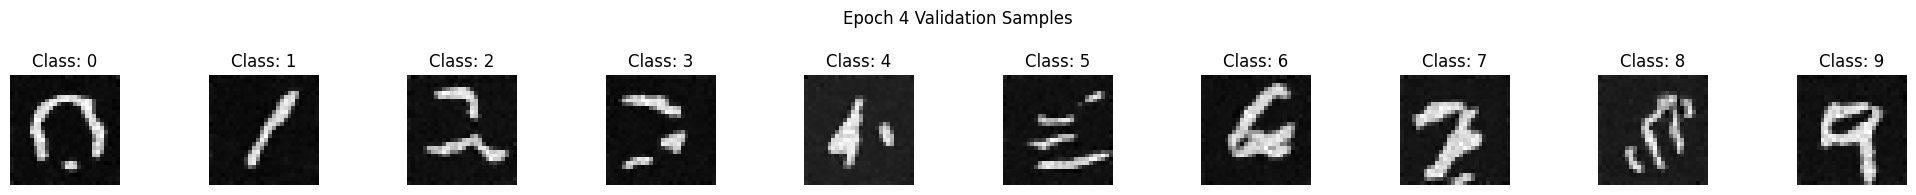

Epoch 5 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.0682 | Val Loss: 0.0737


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

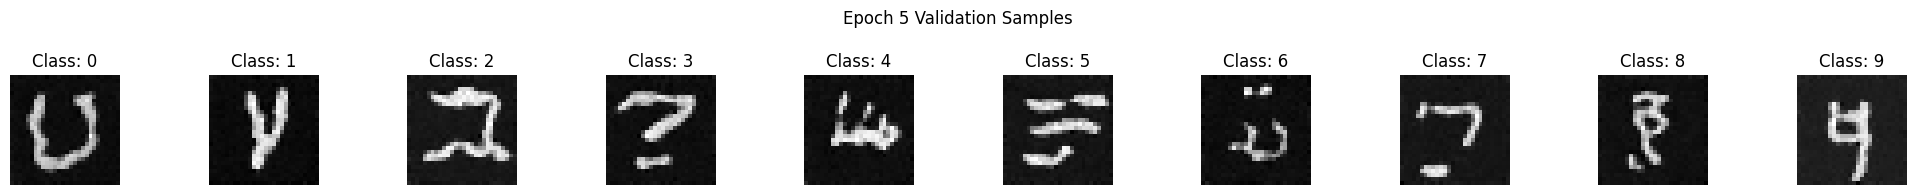

Epoch 6 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.0653 | Val Loss: 0.0678


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

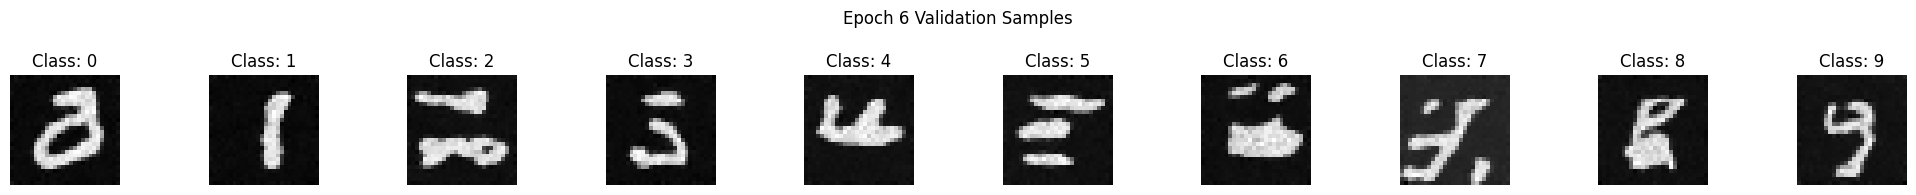

Epoch 7 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.0617 | Val Loss: 0.0626


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

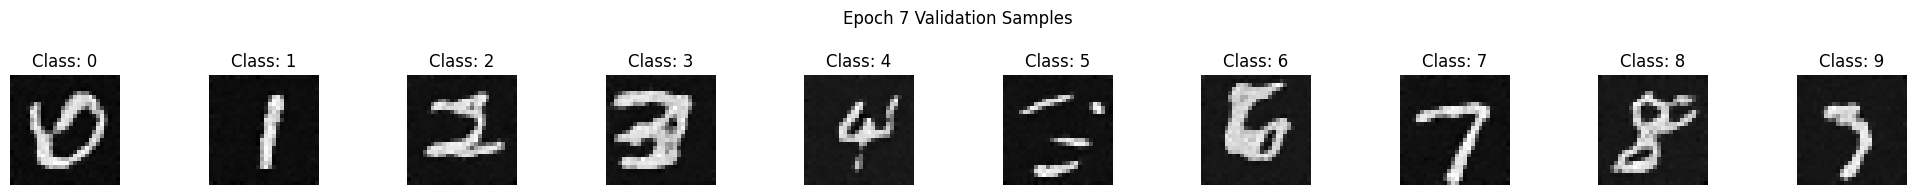

Epoch 8 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.0604 | Val Loss: 0.0584


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

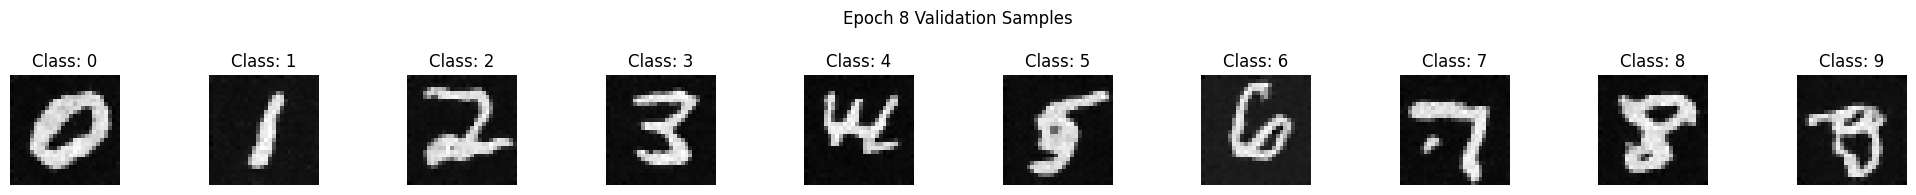

Epoch 9 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.0598 | Val Loss: 0.0576


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

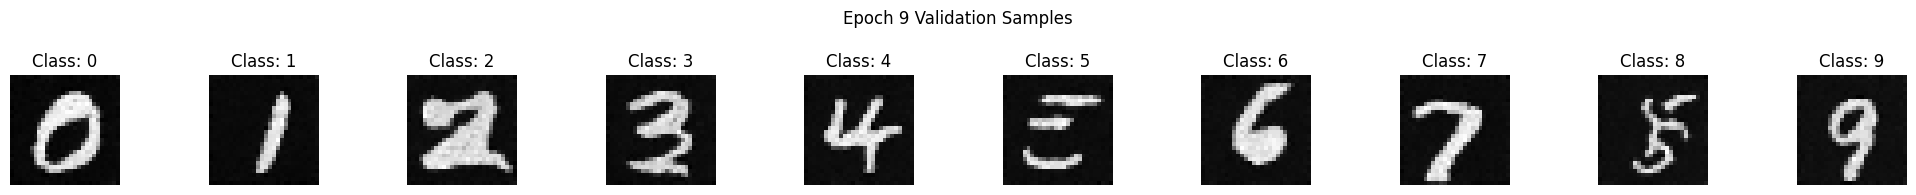

Epoch 10 Train:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0568 | Val Loss: 0.0589


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

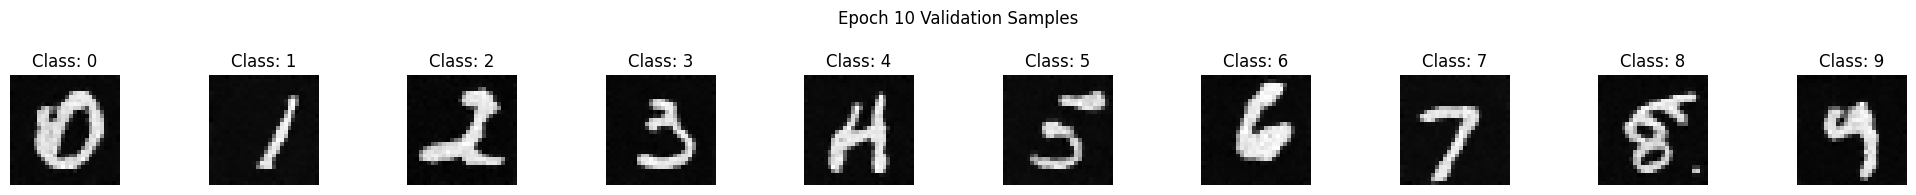


Training complete. Model saved to /content/outputs/ckpts/conditional_ddpm_mnist.pth


In [ ]:
# Helper function for validation samples
@torch.no_grad()
def generate_and_plot_samples(model, epoch, device):
    model.eval()
    fig, axs = plt.subplots(1, Config.NUM_CLASSES, figsize=(20, 2))
    fig.suptitle(f"Epoch {epoch+1} Validation Samples")
    for class_idx in range(Config.NUM_CLASSES):

        x, _ = sample_loop(
            model,
            (Config.SAMPLES_PER_CLASS_VALIDATION, Config.CHANNELS, Config.IMG_SIZE, Config.IMG_SIZE),
            class_idx,
            guidance_scale=3.0
        )


        x = (x + 1) / 2
        axs[class_idx].imshow(x.squeeze().cpu(), cmap='gray')
        axs[class_idx].set_title(f"Class: {class_idx}")
        axs[class_idx].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"/content/outputs/samples/epoch_{epoch+1}_samples.png")
    plt.show()

# Model, Optimizer, Loss
model = ConditionalUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
loss_fn = nn.MSELoss()

# Training Loop
train_losses = []
val_losses = []
print("--- Starting Training ---")

for epoch in range(Config.EPOCHS):
    # Training Step
    model.train()
    epoch_train_loss = 0.0
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Train")
    for batch in train_progress_bar:
        x0, y = batch
        x0, y = x0.to(device), y.to(device)
        t = torch.randint(0, Config.TIMESTEPS, (x0.shape[0],), device=device)
        xt, true_noise = q_sample(x0, t)

        mask = torch.rand(y.shape[0], device=device) > Config.CFG_DROPOUT_PROB
        y_cond = y.clone(); y_cond[~mask] = model.null_class_token

        predicted_noise = model(xt, t, y_cond)
        loss = loss_fn(predicted_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())

    #  Validation Step
    model.eval()
    epoch_val_loss = 0.0
    val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1} Val")
    with torch.no_grad():
        for batch in val_progress_bar:
            x0, y = batch
            x0, y = x0.to(device), y.to(device)
            t = torch.randint(0, Config.TIMESTEPS, (x0.shape[0],), device=device)
            xt, true_noise = q_sample(x0, t)
            predicted_noise = model(xt, t, y)
            loss = loss_fn(predicted_noise, true_noise)
            epoch_val_loss += loss.item()
            val_progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    generate_and_plot_samples(model, epoch, device)


CKPT_PATH = "/content/outputs/ckpts/conditional_ddpm_mnist.pth"
torch.save(model.state_dict(), CKPT_PATH)
print(f"\nTraining complete. Model saved to {CKPT_PATH}")

# 6.1: Reverse Process (`p_sample`) with Classifier-Free Guidance

In [ ]:
@torch.no_grad()
def p_sample(model, xt, t, y, guidance_scale):
    """
    Performs a single reverse diffusion step, including classifier-free guidance.
    - xt: The noisy image at timestep t.
    - t: The current timestep.
    - y: The class label for conditioning.
    - guidance_scale: The strength of the guidance.
    """
    # Create a tensor of the current timestep for batch processing
    t_tensor = torch.full((xt.shape[0],), t, device=device, dtype=torch.long)

    # Classifier-Free Guidance
    # 1. Get the conditional noise prediction (with the class label)
    noise_pred_cond = model(xt, t_tensor, y)

    # 2. Get the unconditional noise prediction (with the null class token)
    null_y = torch.full_like(y, model.null_class_token)
    noise_pred_uncond = model(xt, t_tensor, null_y)

    # 3. Combine the predictions using the guidance scale
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)

    # Denoising Formula
    alpha_t = alphas[t]
    alpha_cumprod_t = alphas_cumprod[t]

    term1 = 1 / torch.sqrt(alpha_t)
    term2 = (1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)

    # Denoise the image by subtracting the predicted noise
    xt_minus_1 = term1 * (xt - term2 * noise_pred)

    # Add back a small amount of noise (except for the last step t=0)
    if t > 0:
        beta_t = betas[t]
        noise = torch.randn_like(xt)
        xt_minus_1 += torch.sqrt(beta_t) * noise

    return xt_minus_1

@torch.no_grad()
def sample_loop(model, shape, class_label, guidance_scale=3.0):
    """
    Generates a full sample by running the entire reverse diffusion loop.
    """
    # Start with pure random noise
    x = torch.randn(shape, device=device)

    # Create a tensor for the desired class label
    y = torch.full((shape[0],), class_label, device=device, dtype=torch.long)

    # Store intermediate steps for visualization
    history = []

    # Loop backwards from the last timestep to the first
    for t in tqdm(reversed(range(Config.TIMESTEPS)), desc=f"Sampling Class {class_label}"):
        x = p_sample(model, x, t, y, guidance_scale)
        # Save a few intermediate steps to visualize the process
        if t % 30 == 0 or t == 0:
            history.append(x.cpu())

    return x.cpu(), history

# Load the trained model for sampling
model = ConditionalUNet().to(device)
model.load_state_dict(torch.load(CKPT_PATH))
model.eval() # Set the model to evaluation mode

print("✅ Sampling functions defined and model loaded.")

✅ Sampling functions defined and model loaded.


7.1: Generate and Visualize Final Samples

--- Visualizing the effect of Classifier-Free Guidance ---


Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

Sampling Class 0: 0it [00:00, ?it/s]

Sampling Class 1: 0it [00:00, ?it/s]

Sampling Class 2: 0it [00:00, ?it/s]

Sampling Class 3: 0it [00:00, ?it/s]

Sampling Class 4: 0it [00:00, ?it/s]

Sampling Class 5: 0it [00:00, ?it/s]

Sampling Class 6: 0it [00:00, ?it/s]

Sampling Class 7: 0it [00:00, ?it/s]

Sampling Class 8: 0it [00:00, ?it/s]

Sampling Class 9: 0it [00:00, ?it/s]

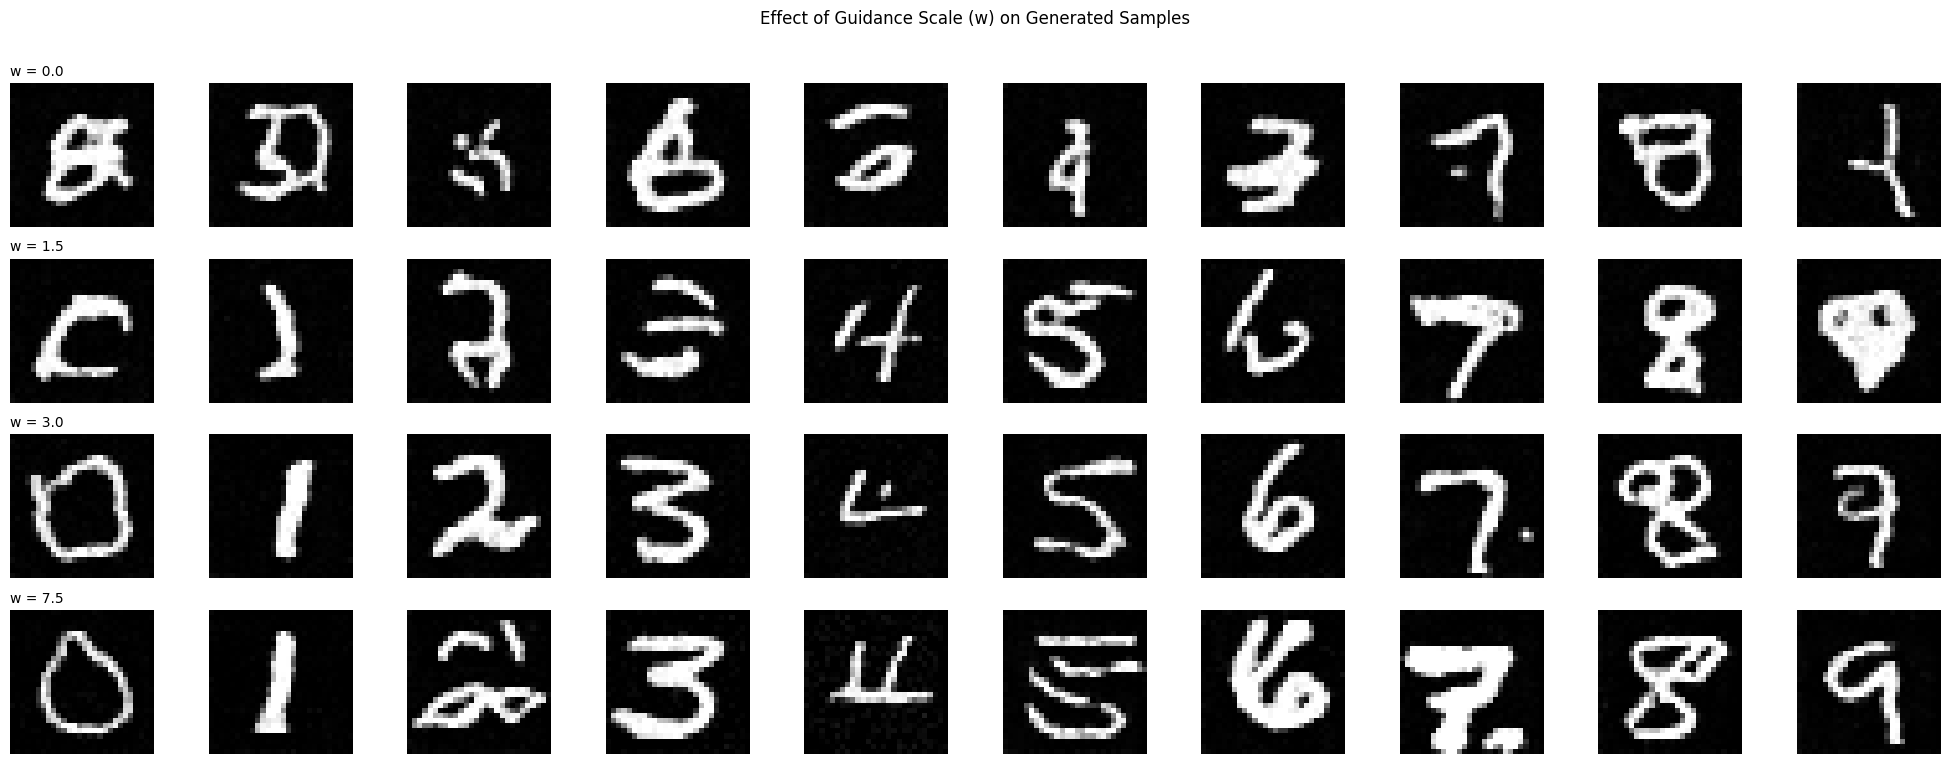


--- Visualizing the full denoising process for a single sample ---


Sampling Class 7: 0it [00:00, ?it/s]

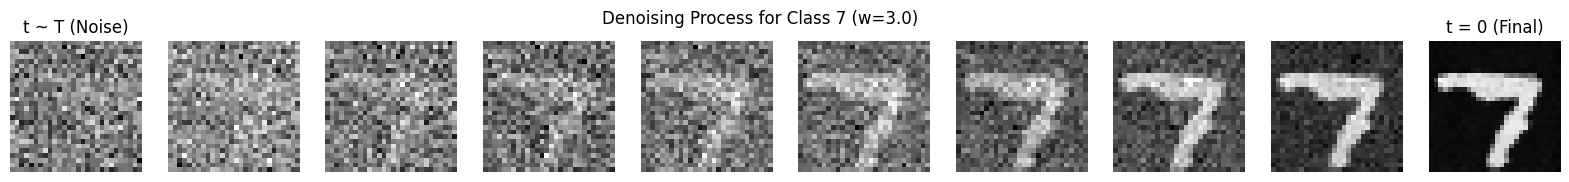

In [ ]:
#  Visualize the effect of the CFG Guidance Scale
print("--- Visualizing the effect of Classifier-Free Guidance ---")
fig, axs = plt.subplots(len(Config.GUIDANCE_SCALES_TO_VISUALIZE), Config.NUM_CLASSES, figsize=(20, 8))
fig.suptitle("Effect of Guidance Scale (w) on Generated Samples")

for i, w in enumerate(Config.GUIDANCE_SCALES_TO_VISUALIZE):
    for class_idx in range(Config.NUM_CLASSES):
        final_sample, _ = sample_loop(
            model,
            (1, Config.CHANNELS, Config.IMG_SIZE, Config.IMG_SIZE),
            class_idx,
            guidance_scale=w
        )

        # Un-normalize from [-1, 1] to [0, 1] for display
        final_sample = (final_sample + 1) / 2
        final_sample = torch.clamp(final_sample, 0, 1)

        # Plot the result
        ax = axs[i, class_idx]
        ax.imshow(final_sample.squeeze(), cmap='gray')
        ax.axis('off')
        if class_idx == 0:
            ax.set_title(f"w = {w}", loc='left', fontsize=10)
        if i == len(Config.GUIDANCE_SCALES_TO_VISUALIZE) - 1:
            ax.set_xlabel(f"Class: {class_idx}", fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("/content/outputs/samples/cfg_effect_grid.png")
plt.show()


# Visualize the denoising process for a single class ---
print("\n--- Visualizing the full denoising process for a single sample ---")
CLASS_TO_VISUALIZE = 7 #@param {type:"slider", min:0, max:9, step:1}
GUIDANCE_FOR_DENOISING_VIZ = 3.0

_, history = sample_loop(
    model,
    (1, Config.CHANNELS, Config.IMG_SIZE, Config.IMG_SIZE),
    CLASS_TO_VISUALIZE,
    guidance_scale=GUIDANCE_FOR_DENOISING_VIZ
)

fig, axs = plt.subplots(1, len(history), figsize=(20, 2))
fig.suptitle(f"Denoising Process for Class {CLASS_TO_VISUALIZE} (w={GUIDANCE_FOR_DENOISING_VIZ})")
for i, img in enumerate(history):
    img = (img + 1) / 2
    axs[i].imshow(img.squeeze(), cmap='gray')
    axs[i].axis('off')
    if i == 0:
        axs[i].set_title("t ~ T (Noise)")
    elif i == len(history) - 1:
        axs[i].set_title("t = 0 (Final)")

plt.savefig(f"/content/outputs/figures/denoising_process_class_{CLASS_TO_VISUALIZE}.png")
plt.show()